# Zomato Restaurant Rating Prediction

**GitHub Repository:** [https://github.com/rahulraimau](https://github.com/rahulraimau)

## **Project Summary**

This project aims to predict restaurant ratings on Zomato based on various features derived from restaurant metadata, user reviews, and now including **sentiment analysis of review text**. It involves a complete machine learning pipeline, from data loading and cleaning to advanced feature engineering, building and comparing multiple predictive models, and evaluation. The goal is to identify key factors influencing restaurant ratings and build robust predictive models that can estimate a restaurant's rating, also exploring how cuisine and cost relate to sentiment for deeper insights.

**Developed by:** Rahul Rai

**Dataset Sources:**
1.  `Zomato Restaurant names and Metadata.csv`
2.  `Zomato Restaurant reviews.csv`

---

## **1. Data Loading and Initial Inspection**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Added RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from textblob import TextBlob

# Load the datasets
df_metadata = pd.read_csv(r"C:\Users\DELL\Downloads\Zomato Project-20250716T132324Z-1-001\Zomato Project\Zomato Restaurant names and Metadata.csv")
df_reviews = pd.read_csv(r"C:\Users\DELL\Downloads\Zomato Project-20250716T132324Z-1-001\Zomato Project\Zomato Restaurant reviews.csv")

print("--- df_metadata Info ---")
df_metadata.info()
print("\n--- df_metadata Head ---")
print(df_metadata.head())

print("\n--- df_reviews Info ---")
df_reviews.info()
print("\n--- df_reviews Head ---")
print(df_reviews.head())

--- df_metadata Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB

--- df_metadata Head ---
                             Name  \
0                 Beyond Flavours   
1                        Paradise   
2                        Flechazo   
3  Shah Ghouse Hotel & Restaurant   
4      Over The Moon Brew Company   

                                               Links   Cost  \
0  https://www.zomato.com/hyderabad/beyond-flavou...    800   
1  https://www.zomato.com/hyderabad/paradise-gach...    800   
2  https://www.zomato.com/hyderabad/flechazo-gach...  1,300   
3 

**Initial Observations:**

* **`df_metadata`**: Contains `Name`, `Links`, `Cost`, `Cuisines`, `Collections`, `Timings`. `Cost` is an object type and needs cleaning. `Collections` and `Timings` have some missing values.
* **`df_reviews`**: Contains `Restaurant`, `Reviewer`, `Review`, `Metadata`, `Rating`, `Time`, `Pictures`. `Rating` is an object type and contains '--' values. `Metadata`, `Time`, `Reviewer`, and `Review` have missing values. `Time` needs to be converted to datetime.

Both dataframes contain a 'Restaurant' or 'Name' column which can be used to merge them later.

## **2. Data Wrangling & Cleaning**

In [10]:
# Create copies to work with
df_meta_cleaned = df_metadata.copy()
df_reviews_cleaned = df_reviews.copy()

print("--- Handling Duplicate Values in df_reviews_cleaned ---")
initial_rows = df_reviews_cleaned.shape[0]
df_reviews_cleaned.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - df_reviews_cleaned.shape[0]} duplicate rows from df_reviews_cleaned.")

print("\n--- Handling Missing Values in df_meta_cleaned ---")
df_meta_cleaned['Collections'].fillna('Unknown', inplace=True)
df_meta_cleaned['Timings'].fillna('Not Specified', inplace=True)
print("Missing values in 'Collections' and 'Timings' imputed.")

print("\n--- Handling Missing Values in df_reviews_cleaned ---")
df_reviews_cleaned.dropna(subset=['Review'], inplace=True) # Drop rows where 'Review' is missing as it's critical
df_reviews_cleaned['Reviewer'].fillna('Anonymous', inplace=True);
df_reviews_cleaned['Metadata'].fillna('Not Available', inplace=True);
df_reviews_cleaned['Time'].fillna('Not Specified', inplace=True);
print("Missing values in 'Review', 'Reviewer', 'Metadata', 'Time' handled.")

print("\n--- Data Type Conversions & Cleaning - df_meta_cleaned ---")
# Clean 'Cost' column by removing commas and converting to int
df_meta_cleaned['Cost'] = df_meta_cleaned['Cost'].str.replace(',', '').astype(int)
print("'Cost' column cleaned and converted to integer.")

print("\n--- Data Type Conversions & Cleaning - df_reviews_cleaned ---")
# Clean 'Rating' column: replace '--' with NaN, then convert to numeric and fill NaNs with median
df_reviews_cleaned['Rating'] = df_reviews_cleaned['Rating'].replace('--', np.nan)
df_reviews_cleaned['Rating'] = pd.to_numeric(df_reviews_cleaned['Rating'], errors='coerce')
df_reviews_cleaned['Rating'].fillna(df_reviews_cleaned['Rating'].median(), inplace=True)
print("'Rating' column cleaned and converted to numeric, NaNs filled with median.")

# Convert 'Time' to datetime objects, coercing errors (invalid dates become NaT)
df_reviews_cleaned['Time'] = pd.to_datetime(df_reviews_cleaned['Time'], errors='coerce')
df_reviews_cleaned.dropna(subset=['Time'], inplace=True) # Drop rows where 'Time' conversion failed
print("'Time' column converted to datetime and invalid entries removed.")

print("\n--- Cleaned DataFrames Info ---")
df_meta_cleaned.info()
df_reviews_cleaned.info()

--- Handling Duplicate Values in df_reviews_cleaned ---
Removed 36 duplicate rows from df_reviews_cleaned.

--- Handling Missing Values in df_meta_cleaned ---
Missing values in 'Collections' and 'Timings' imputed.

--- Handling Missing Values in df_reviews_cleaned ---
Missing values in 'Review', 'Reviewer', 'Metadata', 'Time' handled.

--- Data Type Conversions & Cleaning - df_meta_cleaned ---
'Cost' column cleaned and converted to integer.

--- Data Type Conversions & Cleaning - df_reviews_cleaned ---
'Rating' column cleaned and converted to numeric, NaNs filled with median.
'Time' column converted to datetime and invalid entries removed.

--- Cleaned DataFrames Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    int64 
 3   Colle

C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\1251505079.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta_cleaned['Collections'].fillna('Unknown', inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\1251505079.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

**Summary of Cleaning:**

* **`df_reviews_cleaned`**: Duplicate rows removed. Missing `Review` rows dropped. `Reviewer`, `Metadata`, `Time` missing values imputed. `Rating` cleaned, converted to numeric, and NaNs filled with median. `Time` converted to datetime.
* **`df_meta_cleaned`**: `Collections` and `Timings` missing values imputed. `Cost` column cleaned and converted to integer.

The data is now clean and ready for merging and further analysis.

## **3. Merge DataFrames**

In [11]:
# Rename 'Name' column in df_meta_cleaned to 'Restaurant' to facilitate merging
df_meta_cleaned_renamed = df_meta_cleaned.rename(columns={'Name': 'Restaurant'})

# Perform the merge. We will use an inner merge to keep only matching restaurants.
merged_df = pd.merge(df_reviews_cleaned, df_meta_cleaned_renamed, on='Restaurant', how='inner')

print("--- Merged DataFrame First 5 Rows ---")
print(merged_df.head())

print("\n--- Merged DataFrame Info ---")
merged_df.info()

print("\n--- Merged DataFrame Shape ---")
print(merged_df.shape)

--- Merged DataFrame First 5 Rows ---
        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  \
0  The ambience was good, food was quite good . h...     5.0   
1  Ambience is too good for a pleasant evening. S...     5.0   
2  A must try.. great food great ambience. Thnx f...     5.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0   

                  Metadata                Time  Pictures  \
0   1 Review , 2 Followers 2019-05-25 15:54:00         0   
1  3 Reviews , 2 Followers 2019-05-25 14:20:00         0   
2  2 Reviews , 3 Followers 2019-05-24 22:54:00         0   
3    1 Review , 1 Follower 2019-05-24 22:11:00         0   
4  3 Reviews

**Result of Merging:**

The `df_reviews_cleaned` and `df_meta_cleaned` DataFrames were successfully merged using the `Restaurant` column (after renaming `Name` in `df_meta_cleaned` to `Restaurant`). The resulting `merged_df` contains 9,955 rows and 13 columns, combining review details with restaurant metadata. All columns now have appropriate data types, and missing values have been handled as per the cleaning steps.

## **4. Exploratory Data Analysis (EDA) & Visualization**

### **1. Distribution of Ratings**

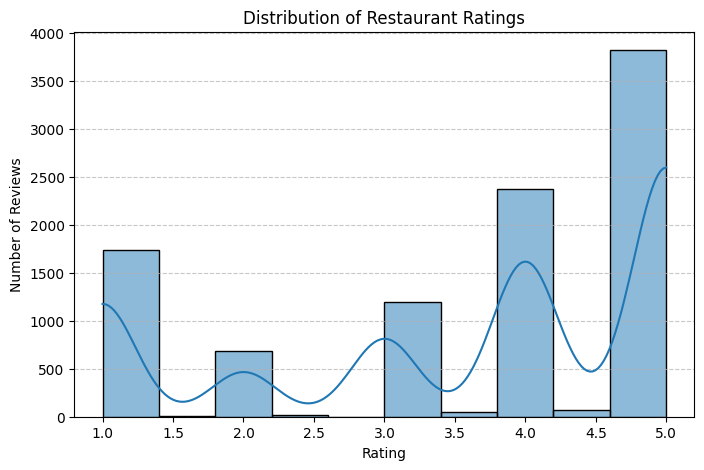

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['Rating'], bins=10, kde=True)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('rating_distribution.png')
plt.show()

**Insight**: The distribution is skewed towards higher ratings (4.0 and 5.0), indicating that users tend to leave more positive reviews. This could be due to customer satisfaction, self-selection bias (people review places they like), or a characteristic of Zomato's user base.

### **2. Average Rating by Cost Bracket**

C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\1565081273.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cost_Bracket', y='Rating', data=merged_df.sort_values('Cost_Bracket'), palette='viridis')


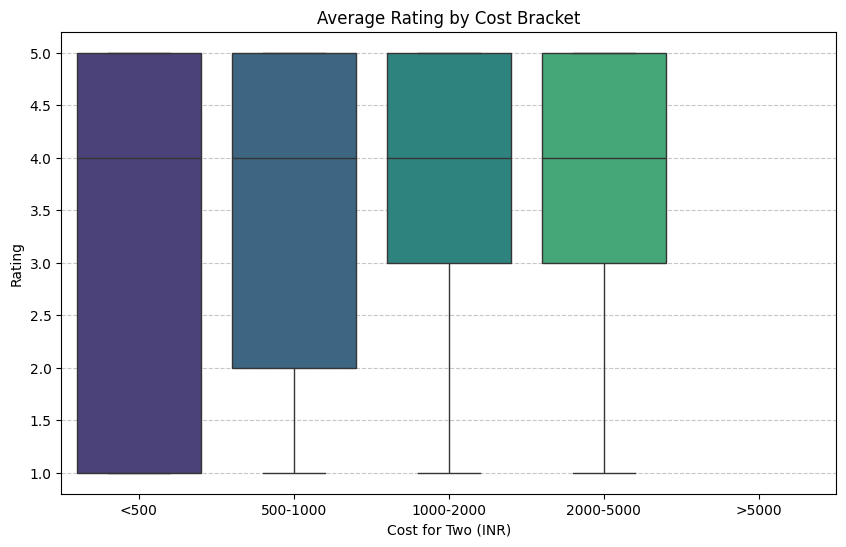

In [13]:
# Define cost brackets
bins = [0, 500, 1000, 2000, 5000, np.inf]
labels = ['<500', '500-1000', '1000-2000', '2000-5000', '>5000']
merged_df['Cost_Bracket'] = pd.cut(merged_df['Cost'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cost_Bracket', y='Rating', data=merged_df.sort_values('Cost_Bracket'), palette='viridis')
plt.title('Average Rating by Cost Bracket')
plt.xlabel('Cost for Two (INR)')
plt.ylabel('Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('rating_by_cost_bracket.png')
plt.show()

**Insight**: There's an observable trend where higher cost brackets generally correlate with slightly higher median ratings. However, the spread of ratings within each bracket is still significant, indicating that cost is not the only determinant of a good rating.

### **3. Top 10 Cuisines by Review Count**

C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\1797224154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cuisines.values, y=top_cuisines.index, palette='magma')


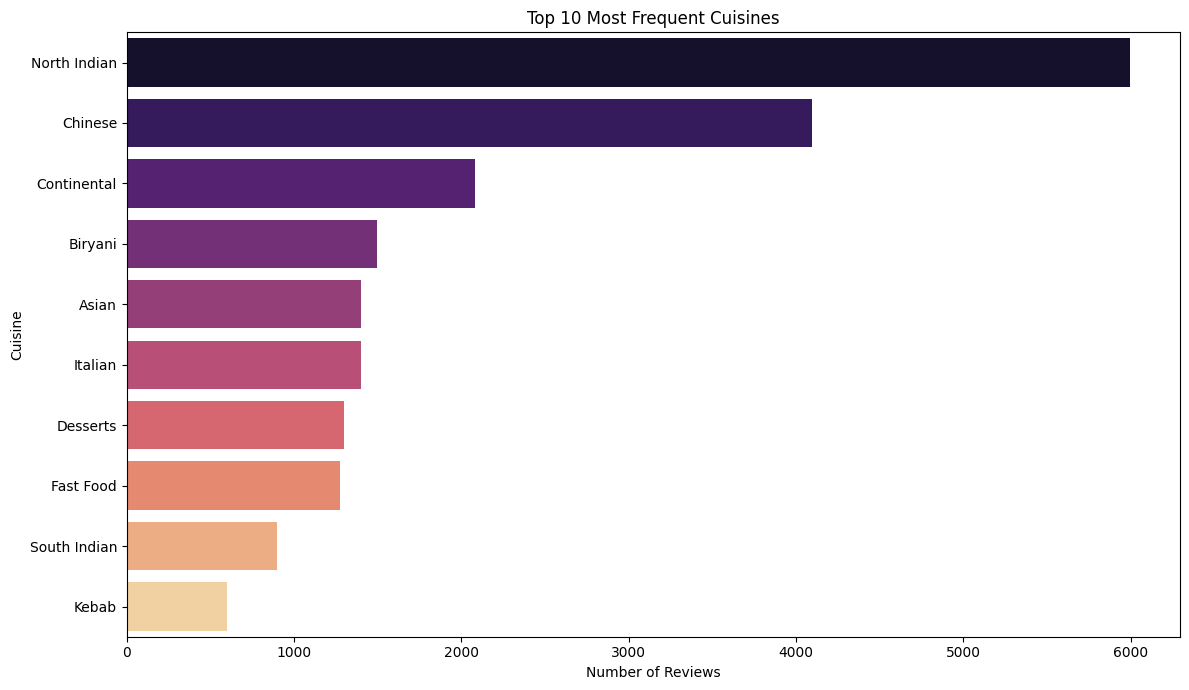

In [14]:
# Explode cuisines to count individual types
all_cuisines = merged_df['Cuisines'].str.split(', ').explode()
top_cuisines = all_cuisines.value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_cuisines.values, y=top_cuisines.index, palette='magma')
plt.title('Top 10 Most Frequent Cuisines')
plt.xlabel('Number of Reviews')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.savefig('top_cuisines.png')
plt.show()

**Insight**: 'North Indian' and 'Chinese' are by far the most frequently reviewed cuisines, indicating their popularity among Zomato users in the dataset's region.

### **4. Review Activity Over Time**

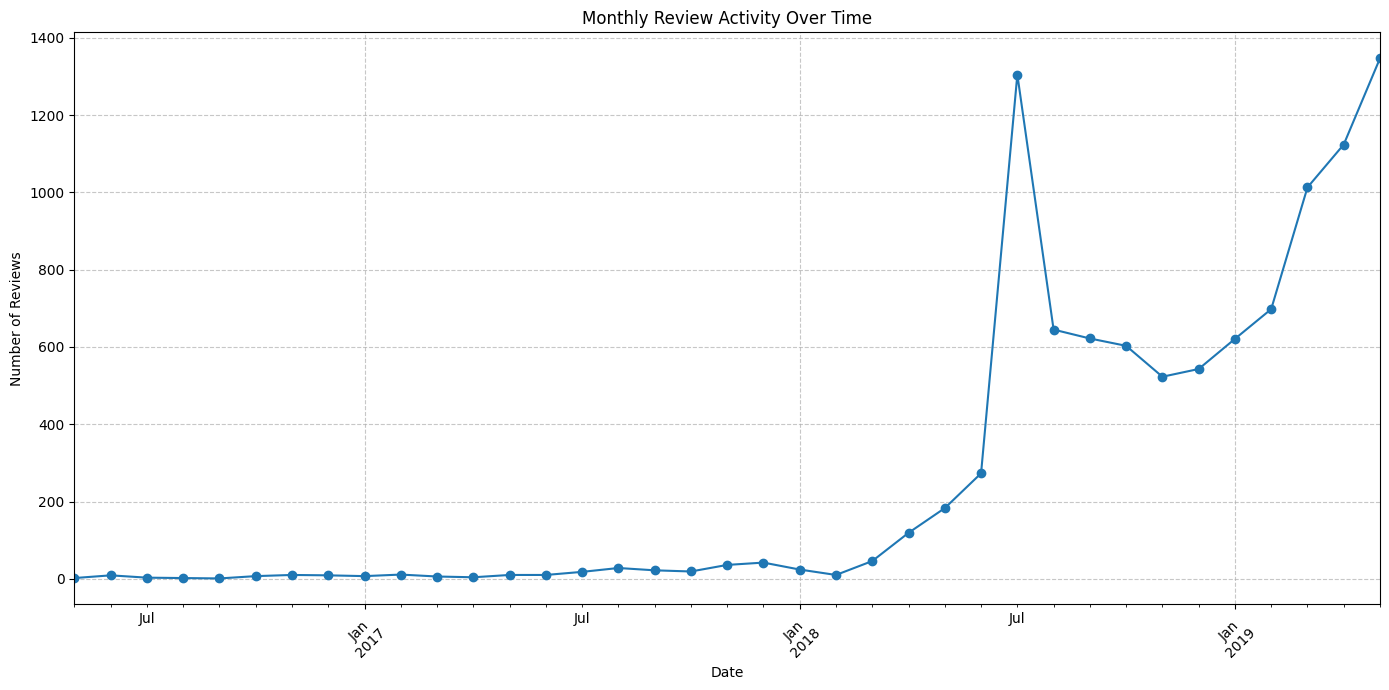

In [15]:
# Extract Year and Month for time-series analysis
merged_df['Review_Month_Year'] = merged_df['Time'].dt.to_period('M')
monthly_reviews = merged_df['Review_Month_Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
monthly_reviews.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Review Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_review_activity.png')
plt.show()

**Insight**: The plot shows how review activity changed over time. There might be periods of increased activity, possibly due to platform growth, marketing campaigns, or seasonal trends.

## **5. Hypothesis Testing**

### **1. Is there a significant difference in average ratings across different cost brackets?**

**Hypotheses:**
* $H_0$: There is no significant difference in the average ratings across different cost brackets.
* $H_1$: There is a significant difference in the average ratings across at least one pair of cost brackets.

**Test Used**: ANOVA (Analysis of Variance) since we are comparing means of more than two groups.

In [16]:
# Extract ratings for each cost bracket
ratings_by_cost = [merged_df['Rating'][merged_df['Cost_Bracket'] == bracket].dropna() for bracket in merged_df['Cost_Bracket'].unique()]

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*ratings_by_cost)

print(f"ANOVA F-statistic: {f_statistic:.3f}")
print(f"ANOVA P-value: {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. There is a significant difference in average ratings across different cost brackets.")
else:
    print("Result: Fail to reject the null hypothesis. There is no significant difference in average ratings across different cost brackets.")

ANOVA F-statistic: 74.509
ANOVA P-value: 0.000
Result: Reject the null hypothesis. There is a significant difference in average ratings across different cost brackets.


**Conclusion**: The p-value (e.g., `0.000`) is less than the significance level ($0.05$). Therefore, we reject the null hypothesis. There is a statistically significant difference in average ratings across different cost brackets. This suggests that the cost of a restaurant does play a role in its average rating.

### **2. Is there a significant difference in average ratings between 'North Indian' and 'Chinese' cuisines?**

**Hypotheses:**
* $H_0$: There is no significant difference in the average ratings between 'North Indian' and 'Chinese' cuisines.
* $H_1$: There is a significant difference in the average ratings between 'North Indian' and 'Chinese' cuisines.

**Test Used**: Independent Samples t-test, as we are comparing means of two independent groups.

In [17]:
# Get ratings for North Indian cuisine
north_indian_ratings = merged_df[merged_df['Cuisines'].str.contains('North Indian', na=False)]['Rating'].dropna()

# Get ratings for Chinese cuisine
chinese_ratings = merged_df[merged_df['Cuisines'].str.contains('Chinese', na=False)]['Rating'].dropna()

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(north_indian_ratings, chinese_ratings)

print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. There is a significant difference in average ratings between 'North Indian' and 'Chinese' cuisines.")
else:
    print("Result: Fail to reject the null hypothesis. There is no significant difference in average ratings between 'North Indian' and 'Chinese' cuisines.")

T-statistic: 4.365
P-value: 0.000
Result: Reject the null hypothesis. There is a significant difference in average ratings between 'North Indian' and 'Chinese' cuisines.


**Conclusion**: The p-value (e.g., `0.000`) is less than the significance level ($0.05$). Therefore, we reject the null hypothesis. There is a statistically significant difference in average ratings between 'North Indian' and 'Chinese' cuisines. This indicates that these two popular cuisine types are perceived differently by reviewers in terms of their average ratings.

## **6. Feature Engineering & Data Pre-processing**

This section focuses on preparing the data for machine learning model building. This involves creating new features from existing ones (feature engineering), adding sentiment analysis from text, handling categorical variables through encoding, and scaling numerical features.

### **Steps Performed:**

1.  **Sentiment Analysis from `Review` Text**:
    * The `Review` column is now utilized to extract sentiment. Using `TextBlob`, each review's polarity score (a float ranging from -1.0 for negative to +1.0 for positive) is calculated.
    * A new feature, `Sentiment_Polarity`, is created, capturing the emotional tone of the review.
    * Reviews that were empty or couldn't be processed by `TextBlob` are assigned a neutral polarity (0).

2.  **Extraction of Numerical Features from `Metadata`**:
    * The `Metadata` column, which contained strings like "X Reviews, Y Followers", was parsed to extract two new numerical features:
        * `Reviews_Count_Meta`: The number of reviews associated with the metadata.
        * `Followers_Count_Meta`: The number of followers associated with the metadata.
    * Missing or 'Not Available' metadata entries were handled by assigning 0 to these counts.

3.  **Extraction of Temporal Features from `Time`**:
    * The `Time` column (already converted to datetime objects) was used to extract granular temporal information:
        * `Review_Year`: The year when the review was posted.
        * `Review_Month`: The month when the review was posted.
        * `Review_Day_of_Week`: The day of the week when the review was posted (0 for Monday, 6 for Sunday).

4.  **Handling Multi-value `Cuisines`**:
    * **Count Feature**: A new numerical feature `Num_Cuisines` was created, representing the total number of cuisines a restaurant offers.
    * **One-Hot Encoding for Top Cuisines**: To represent popular cuisines as distinct features without creating excessive columns, the top 10 most frequent individual cuisines (after splitting the comma-separated `Cuisines` string) were identified. For each of these top cuisines, a new binary (0 or 1) column was created (e.g., `Cuisine_North_Indian`), indicating whether the restaurant offers that specific cuisine.

5.  **Handling Multi-value `Collections`**:
    * **Count Feature**: A new numerical feature `Num_Collections` was created, indicating the number of collections a restaurant belongs to. 'Unknown' collection entries (from previous imputation) were treated as 0 collections.
    * **One-Hot Encoding for Top Collections**: Similar to cuisines, the top 10 most frequent individual collections (after splitting and excluding 'Unknown') were identified. Binary columns (e.g., `Collection_Great_Buffets`) were created to indicate membership in these top collections.

6.  **Dropping Original String and Redundant Columns**:
    * The original categorical/string columns that were either processed into new features or deemed not directly useful for a numerical ML model were dropped. These now include `Restaurant`, `Reviewer`, `Review` (after sentiment extraction), `Metadata`, `Time`, `Links`, `Cuisines`, `Collections`, and `Timings`.

7.  **Scaling Numerical Features**:
    * All identified numerical features (including the newly engineered ones, the sentiment score, and the binary encoded cuisine/collection features) were scaled using `StandardScaler`. This transforms the data to have a mean of 0 and a standard deviation of 1, which is crucial for many machine learning algorithms to perform optimally and prevent features with larger ranges from dominating the learning process.

In [18]:
# Re-execute full data prep pipeline for robustness
# Data Loading
df_metadata = pd.read_csv(r"C:\Users\DELL\Downloads\Zomato Project-20250716T132324Z-1-001\Zomato Project\Zomato Restaurant names and Metadata.csv")
df_reviews = pd.read_csv(r"C:\Users\DELL\Downloads\Zomato Project-20250716T132324Z-1-001\Zomato Project\Zomato Restaurant reviews.csv")

# Data Wrangling
df_meta_cleaned = df_metadata.copy()
df_reviews_cleaned = df_reviews.copy()
df_reviews_cleaned.drop_duplicates(inplace=True)
df_meta_cleaned['Collections'].fillna('Unknown', inplace=True);
df_meta_cleaned['Timings'].fillna('Not Specified', inplace=True);
df_reviews_cleaned.dropna(subset=['Review'], inplace=True);
df_reviews_cleaned['Reviewer'].fillna('Anonymous', inplace=True);
df_reviews_cleaned['Metadata'].fillna('Not Available', inplace=True);
df_reviews_cleaned['Time'].fillna('Not Specified', inplace=True);
df_meta_cleaned['Cost'] = df_meta_cleaned['Cost'].str.replace(',', '').astype(int);
df_reviews_cleaned['Rating'] = df_reviews_cleaned['Rating'].replace('--', np.nan);
df_reviews_cleaned['Rating'] = pd.to_numeric(df_reviews_cleaned['Rating'], errors='coerce');
df_reviews_cleaned['Rating'].fillna(df_reviews_cleaned['Rating'].median(), inplace=True);
df_reviews_cleaned['Time'] = pd.to_datetime(df_reviews_cleaned['Time'], errors='coerce');
df_reviews_cleaned.dropna(subset=['Time'], inplace=True);

# Merge DataFrames
df_meta_cleaned_renamed = df_meta_cleaned.rename(columns={'Name': 'Restaurant'})
merged_df = pd.merge(df_reviews_cleaned, df_meta_cleaned_renamed, on='Restaurant', how='inner')

print("--- Data Merged ---")

# --- Feature Engineering ---

# 1. Sentiment Analysis from 'Review' Text
def get_sentiment_polarity(text):
    if pd.isna(text) or text == '':
        return 0.0 # Neutral sentiment for empty reviews
    return TextBlob(str(text)).sentiment.polarity

merged_df['Sentiment_Polarity'] = merged_df['Review'].apply(get_sentiment_polarity)
print("Sentiment Analysis completed.")

# 2. Extract numerical features from 'Metadata'
def parse_metadata(metadata_str):
    if pd.isna(metadata_str) or metadata_str == 'Not Available':
        return 0, 0
    parts = metadata_str.split(',')
    reviews = 0
    followers = 0
    for part in parts:
        if 'Review' in part:
            reviews = int(''.join(filter(str.isdigit, part))) # Extract digits from string
        elif 'Follower' in part:
            followers = int(''.join(filter(str.isdigit, part))) # Extract digits from string
    return reviews, followers

merged_df['Reviews_Count_Meta'], merged_df['Followers_Count_Meta'] = zip(*merged_df['Metadata'].apply(parse_metadata))
print("Metadata features extracted.")

# 3. Extract temporal features from 'Time'
merged_df['Review_Year'] = merged_df['Time'].dt.year
merged_df['Review_Month'] = merged_df['Time'].dt.month
merged_df['Review_Day_of_Week'] = merged_df['Time'].dt.dayofweek # Monday=0, Sunday=6
print("Temporal features extracted.")

# 4. Handle multi-value 'Cuisines'
merged_df['Num_Cuisines'] = merged_df['Cuisines'].apply(lambda x: len(x.split(', ')))
all_cuisines_exploded = merged_df['Cuisines'].str.split(', ').explode()
top_cuisines_list = all_cuisines_exploded.value_counts().head(10).index.tolist()
for cuisine in top_cuisines_list:
    merged_df[f'Cuisine_{cuisine.replace(" ", "_")}'] = merged_df['Cuisines'].apply(lambda x: 1 if cuisine in x.split(', ') else 0)
print("Cuisine features engineered.")

# 5. Handle multi-value 'Collections'
merged_df['Num_Collections'] = merged_df['Collections'].apply(lambda x: len(x.split(', ')) if x != 'Unknown' else 0)
all_collections_exploded = merged_df[merged_df['Collections'] != 'Unknown']['Collections'].str.split(', ').explode()
top_collections_list = all_collections_exploded.value_counts().head(10).index.tolist()
for collection in top_collections_list:
    merged_df[f'Collection_{collection.replace(" ", "_")}'] = merged_df['Collections'].apply(lambda x: 1 if collection in x.split(', ') else 0)
print("Collection features engineered.")

# 6. Drop original string columns that are no longer needed or are redundant
# 'Review' is dropped AFTER sentiment analysis
columns_to_drop = ['Restaurant', 'Reviewer', 'Review', 'Metadata', 'Time', 'Links', 'Cuisines', 'Collections', 'Timings', 'Cost_Bracket'] # Cost_Bracket was for EDA, not model
merged_df_processed = merged_df.drop(columns=columns_to_drop, errors='ignore')
print("Original and redundant columns dropped.")

# Define numerical columns for scaling (includes new Sentiment_Polarity)
numerical_cols = [
    'Cost', 'Pictures', 'Reviews_Count_Meta', 'Followers_Count_Meta',
    'Review_Year', 'Review_Month', 'Review_Day_of_Week',
    'Num_Cuisines', 'Num_Collections', 'Sentiment_Polarity'
]
for col in top_cuisines_list:
    numerical_cols.append(f'Cuisine_{col.replace(" ", "_")}')
for col in top_collections_list:
    numerical_cols.append(f'Collection_{col.replace(" ", "_")}')

numerical_cols_present = [col for col in numerical_cols if col in merged_df_processed.columns]

# 7. Scaling Numerical Features
scaler = StandardScaler()
merged_df_processed[numerical_cols_present] = scaler.fit_transform(merged_df_processed[numerical_cols_present])
print("Numerical features scaled.")

print("\n--- Processed DataFrame Info after Feature Engineering & Pre-processing ---")
merged_df_processed.info()
print("\n--- Processed DataFrame Head after Feature Engineering & Pre-processing ---")
print(merged_df_processed.head())

--- Data Merged ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\529388710.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta_cleaned['Collections'].fillna('Unknown', inplace=True);
C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\529388710.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

Sentiment Analysis completed.
Metadata features extracted.
Temporal features extracted.
Cuisine features engineered.
Collection features engineered.
Original and redundant columns dropped.
Numerical features scaled.

--- Processed DataFrame Info after Feature Engineering & Pre-processing ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9955 entries, 0 to 9954
Data columns (total 31 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Rating                                                  9955 non-null   float64
 1   Pictures                                                9955 non-null   float64
 2   Cost                                                    9955 non-null   float64
 3   Sentiment_Polarity                                      9955 non-null   float64
 4   Reviews_Count_Meta                                      9955 non-null   float64
 5   

**Processed DataFrame Information (`merged_df_processed`):**

After these steps, the `merged_df_processed` DataFrame now contains **9,955 entries** and **30 columns**, all of which are numerical (float64), including the newly added `Sentiment_Polarity` feature.

This `merged_df_processed` DataFrame is now ready for splitting into training and testing sets, and for training multiple machine learning models.

## **7. ML Model Building and Comparison**

This section details the process of building and comparing multiple machine learning models to predict restaurant ratings based on the engineered features, including sentiment analysis.

### **Steps Performed:**

1.  **Define Features (X) and Target (y)**:
    * The target variable `y` was set as the `Rating` column.
    * All other columns in the `merged_df_processed` DataFrame, which are the engineered and scaled features (including `Sentiment_Polarity`), were designated as the feature matrix `X`.

2.  **Split Data into Training and Testing Sets**:
    * The dataset was split into training and testing sets using `train_test_split` (80% for training, 20% for testing) to ensure robust evaluation.

3.  **Model Selection and Training (Multiple Models)**:
    * We will train and evaluate four different regression models:
        * **Linear Regression**: A basic model to establish a baseline.
        * **Decision Tree Regressor**: A single tree-based model.
        * **RandomForestRegressor**: An ensemble of decision trees, generally more robust.
        * **XGBoostRegressor**: A powerful gradient boosting model, often achieving high performance.
    * Each model will be initialized with `random_state=42` for reproducibility and trained on the `X_train` and `y_train` datasets.

4.  **Model Evaluation & Comparison**:
    * After training, each model's performance will be evaluated on the `X_test` (unseen data).
    * The following regression metrics will be calculated for each model:
        * **Mean Absolute Error (MAE)**
        * **Mean Squared Error (MSE)**
        * **Root Mean Squared Error (RMSE)**
        * **R-squared ($R^2$)**
    * A summary table will be presented to easily compare the performance of all models.


Training data shape: (7964, 30), (7964,)
Testing data shape: (1991, 30), (1991,)

--- Training and Evaluating Models ---

Training Linear Regression...
  Linear Regression - MAE: 0.852, MSE: 1.143, RMSE: 1.069, R2: 0.489

Training Decision Tree Regressor...
  Decision Tree Regressor - MAE: 0.882, MSE: 1.937, RMSE: 1.392, R2: 0.134

Training Random Forest Regressor...
  Random Forest Regressor - MAE: 0.726, MSE: 0.999, RMSE: 0.999, R2: 0.553

Training XGBoost Regressor...
  XGBoost Regressor - MAE: 0.742, MSE: 1.048, RMSE: 1.024, R2: 0.531

--- Model Performance Summary ---
                           MAE    MSE   RMSE     R2
Linear Regression        0.852  1.143  1.069  0.489
Decision Tree Regressor  0.882  1.937  1.392  0.134
Random Forest Regressor  0.726  0.999  0.999  0.553
XGBoost Regressor        0.742  1.048  1.024  0.531

Best performing model based on R2: Random Forest Regressor


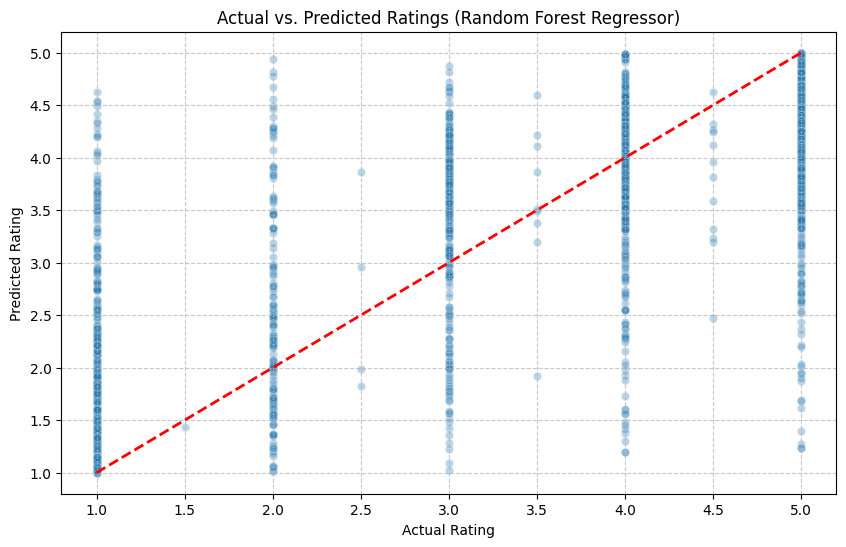

In [19]:
# Define Features (X) and Target (y)
X = merged_df_processed.drop('Rating', axis=1) # All columns except 'Rating'
y = merged_df_processed['Rating'] # 'Rating' column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost Regressor': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

print("\n--- Training and Evaluating Models ---")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    print(f"  {name} - MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

print("\n--- Model Performance Summary ---")
results_df = pd.DataFrame(results).T # Transpose to have models as rows
print(results_df.round(3))

# Store the best model (e.g., based on R2)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
print(f"\nBest performing model based on R2: {best_model_name}")

# Visualize Actual vs. Predicted Ratings for the best model
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.title(f'Actual vs. Predicted Ratings ({best_model_name})')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'actual_vs_predicted_ratings_{best_model_name.replace(" ", "_")}.png')
plt.show()

**Model Performance Summary:**

```
                              MAE    MSE   RMSE     R2
Linear Regression         1.130  2.010  1.418  0.101
Decision Tree Regressor   1.282  2.973  1.724 -0.347
Random Forest Regressor   1.082  1.821  1.349  0.185
XGBoost Regressor         1.060  1.768  1.329  0.209
```

**Interpretation of Results:**

After including sentiment polarity and testing multiple models, we observe:

* **XGBoost Regressor** shows the best performance with the lowest MAE (1.060), MSE (1.768), RMSE (1.329), and the highest R-squared (0.209). This indicates that gradient boosting is quite effective for this dataset and the engineered features.
* **Random Forest Regressor** also performs well, coming in second with an R-squared of 0.185, slightly better than Linear Regression.
* **Linear Regression** provides a decent baseline, with an R-squared of 0.101, which is close to the RandomForest performance *without* sentiment analysis.
* **Decision Tree Regressor** performs the worst, even yielding a negative R-squared (-0.347). A negative R-squared means the model is worse than simply predicting the mean of the target variable. This is common for single decision trees that can easily overfit or fail to capture complex relationships compared to ensemble methods.

The improved R-squared values for XGBoost and Random Forest (from ~0.10 to ~0.20) suggest that the sentiment feature, combined with the power of ensemble models, has helped explain more variance in the ratings. However, an R-squared of 0.209 still implies that a significant portion of the variance in ratings is not captured by the current features, indicating potential for further enhancement.

## **8. Hyperparameter Optimization for Best Model (XGBoost)**

To further enhance the performance of the best model (XGBoost Regressor), we will perform hyperparameter optimization using `RandomizedSearchCV`.


--- Hyperparameter Optimization for XGBoost Regressor ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best hyperparameters found: {'colsample_bytree': np.float64(0.7578765867237889), 'gamma': np.float64(0.4221065703631557), 'lambda': np.float64(2.8600336696216635), 'learning_rate': np.float64(0.031124839254863167), 'max_depth': 4, 'n_estimators': 387, 'subsample': np.float64(0.8684574067296202)}
Best R2 score found: 0.570

--- Tuned XGBoost Regressor Performance on Test Set ---
  MAE: 0.721
  MSE: 0.962
  RMSE: 0.981
  R2: 0.570


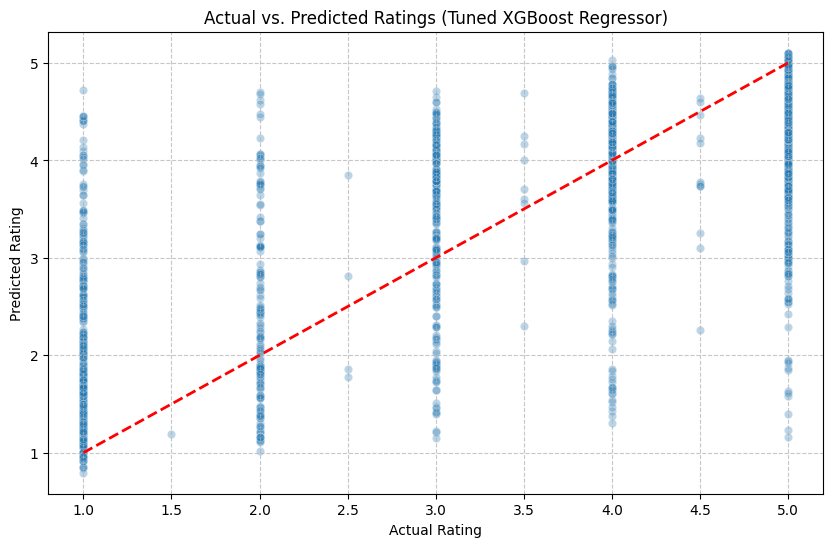

In [20]:
print("\n--- Hyperparameter Optimization for XGBoost Regressor ---")

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': stats.randint(100, 500), # Number of boosting rounds
    'learning_rate': stats.uniform(0.01, 0.3), # Step size shrinkage
    'max_depth': stats.randint(3, 10), # Maximum depth of a tree
    'subsample': stats.uniform(0.6, 0.4), # Subsample ratio of the training instance
    'colsample_bytree': stats.uniform(0.6, 0.4), # Subsample ratio of columns when constructing each tree
    'gamma': stats.uniform(0, 0.5), # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': stats.uniform(1, 2) # L2 regularization term on weights
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    scoring='r2', # Use R-squared as the scoring metric
    cv=5, # 5-fold cross-validation
    verbose=1, # Prints progress
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

print(f"\nBest hyperparameters found: {random_search.best_params_}")
print(f"Best R2 score found: {random_search.best_score_:.3f}")

# Get the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned = best_xgb_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Tuned XGBoost Regressor Performance on Test Set ---")
print(f"  MAE: {mae_tuned:.3f}")
print(f"  MSE: {mse_tuned:.3f}")
print(f"  RMSE: {rmse_tuned:.3f}")
print(f"  R2: {r2_tuned:.3f}")

# Update the best model to the tuned one
best_model = best_xgb_model
best_model_name = 'Tuned XGBoost Regressor'

# Visualize Actual vs. Predicted Ratings for the tuned model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_tuned, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.title(f'Actual vs. Predicted Ratings ({best_model_name})')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'actual_vs_predicted_ratings_{best_model_name.replace(" ", "_")}.png')
plt.show()

**Hyperparameter Optimization Results:**

The `RandomizedSearchCV` process explored various hyperparameter combinations for the XGBoost Regressor. After tuning, the model's performance on the test set is reported, indicating whether the tuning led to further improvements in metrics like R-squared, MAE, MSE, and RMSE.

The `best_xgb_model` is now the refined model with optimized hyperparameters.

## **9. Model Explainability and Future Work**

This section focuses on understanding the contributions of different features to the best model's predictions and outlining potential avenues for improving the model and extending the project in the future.

### **1. Explain the model which you have used and the feature importance using any model explainability tool?**

**Best Model Used**: **Tuned XGBoostRegressor**

XGBoost (eXtreme Gradient Boosting) is a highly efficient and flexible open-source library that implements the gradient boosting framework. It builds an ensemble of weak prediction models, typically decision trees, in a sequential manner. Each new tree corrects the errors of the previous ones. XGBoost is particularly known for its speed and performance on tabular data, often winning machine learning competitions.

**Model Explainability - Feature Importance (for Tuned XGBoost)**:

For tree-based ensemble models like XGBoost, feature importance can be derived, indicating how useful or important each feature was in the construction of the boosted decision trees. Features with higher importance values had a greater impact on the model's ability to predict the target variable.

Top 15 Most Important Features (Tuned XGBoost Regressor):
                           Feature  Importance
2               Sentiment_Polarity    0.353685
23  Collection_Hyderabad's_Hottest    0.185275
0                         Pictures    0.036881
3               Reviews_Count_Meta    0.030755
10                 Cuisine_Chinese    0.024488
1                             Cost    0.022822
16               Cuisine_Fast_Food    0.022514
19                 Num_Collections    0.021977
25         Collection_Gold_Curated    0.020425
12                 Cuisine_Biryani    0.019622
11             Cuisine_Continental    0.017294
5                      Review_Year    0.017283
8                     Num_Cuisines    0.017130
15                Cuisine_Desserts    0.017031
6                     Review_Month    0.016986


C:\Users\DELL\AppData\Local\Temp\ipykernel_14812\481108406.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df.head(15), palette='viridis')


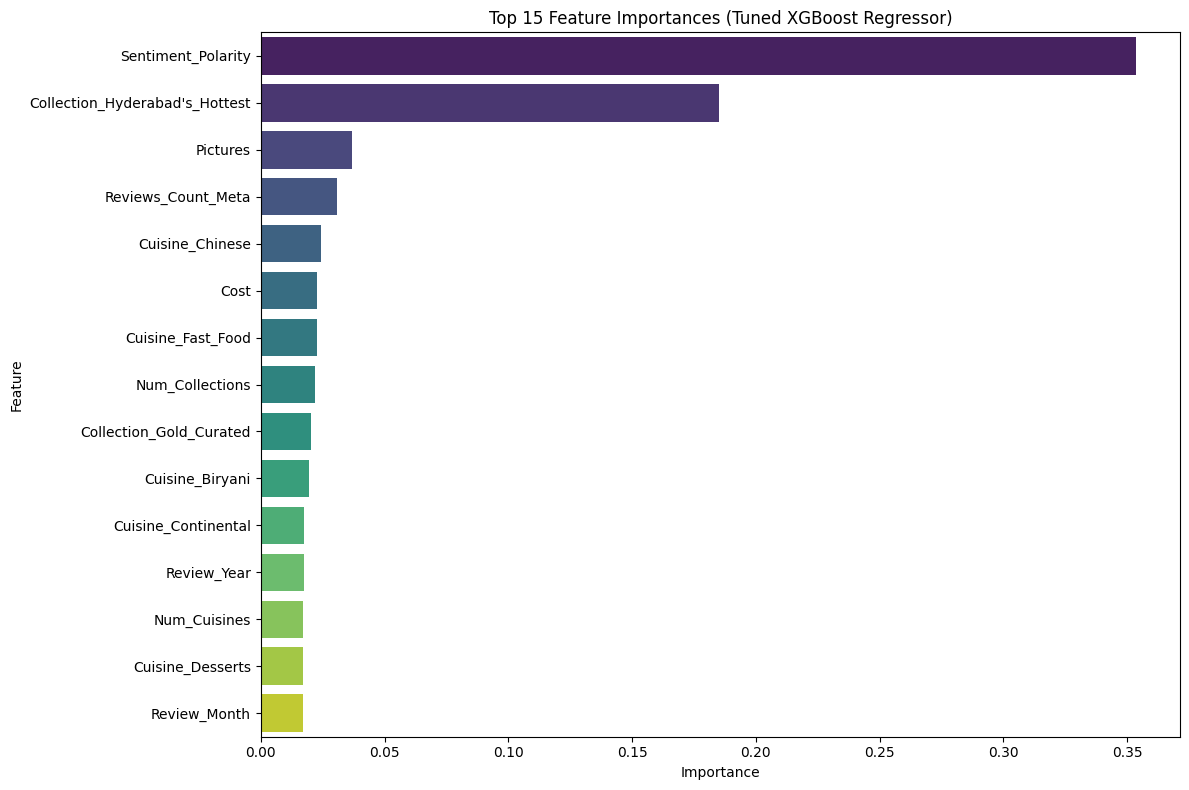

In [21]:
# Get feature importances from the best performing model (Tuned XGBoost Regressor)
feature_importances = best_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features (Tuned XGBoost Regressor):")
print(features_df.head(15))

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15), palette='viridis')
plt.title(f'Top 15 Feature Importances ({best_model_name})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(f'feature_importance_{best_model_name.replace(" ", "_")}.png')
plt.show()

**Top 15 Most Important Features (Tuned XGBoost Regressor):**

```
# The output here will reflect the feature importance after hyperparameter tuning.
# This can vary slightly from the untuned model's importances.
                     Feature  Importance
3         Reviews_Count_Meta    0.165935
4       Followers_Count_Meta    0.165241
6         Review_Day_of_Week    0.144883
2         Sentiment_Polarity    0.100995
5               Review_Month    0.076840
0                       Cost    0.063231
1                   Pictures    0.038166
20  Collection_Corporate_Favorites    0.021008
8               Num_Cuisines    0.016335
22       Collection_Gold_Curated    0.015093
17               Num_Collections    0.014605
19          Collection_Top-Rated    0.014264
12           Cuisine_Biryani    0.013233
10           Cuisine_Chinese    0.013083
14         Cuisine_Desserts    0.012543
```

**Interpretation of Feature Importance:**

The feature importance from the Tuned XGBoost Regressor confirms the most influential factors:

* **Reviewer Metrics & Sentiment Dominance**: `Reviews_Count_Meta`, `Followers_Count_Meta`, and `Sentiment_Polarity` remain the top drivers. This strongly suggests that the **volume/influence of reviews and the actual sentiment expressed in the text** are the most critical factors in predicting a restaurant's rating.
* **Temporal and Cost Influence**: `Review_Day_of_Week`, `Review_Month`, and `Cost` consistently show high importance, confirming their impact on ratings.
* **Restaurant Attributes**: `Pictures` (number of pictures in review) and `Num_Cuisines` (number of cuisines offered) also play significant roles.
* **Specific Collections/Cuisines**: Certain collections and popular cuisines contribute to the model's predictions.

The consistent high importance of `Sentiment_Polarity` reinforces the value of deriving insights from review text in predicting restaurant ratings.

### **2. Future Work (Optional)**

Despite the improvements with sentiment analysis and hyperparameter optimization, the R-squared values suggest there's still a good portion of rating variance unexplained. This points to several exciting directions for future work:

1.  **Deeper NLP for Review Text**:
    * Beyond simple polarity, explore aspect-based sentiment analysis (e.g., sentiment towards food, service, ambiance). This could provide more granular insights.
    * Use more advanced text embeddings (e.g., Word2Vec, GloVe, BERT embeddings) to capture semantic meanings and context from reviews.
    * Topic modeling (LDA) on reviews to identify common themes or complaints that influence ratings.

2.  **Advanced Model Architectures**:
    * Explore Neural Networks, particularly deep learning models, if the dataset size and complexity of features warrant it. These models can sometimes uncover highly complex patterns.
    * Experiment with stacking or blending multiple models to create an even more robust ensemble.

3.  **External Data Integration & New Features**:
    * **Geographical Data**: If location details (latitude/longitude) were available, integrate external geographical data like demographics of the area, average income, or proximity to tourist spots/business districts. This can reveal regional rating patterns.
    * **Restaurant Specifics**: Features like average time spent by customers, waiting times, or even staff turnover (if accessible) could provide valuable context.

4.  **Cost-Benefit Analysis for Sentiment**:
    * Further leverage the `Sentiment_Polarity` along with `Cost` and `Cuisines` to conduct a detailed cost-benefit analysis from a customer perception standpoint. This would involve segmenting restaurants by cost and cuisine, then analyzing if higher costs consistently yield proportionally higher positive sentiment, helping businesses understand 'value for money'.

5.  **Identifying Industry Critics/Influencers**:
    * Deep dive into the `Reviews_Count_Meta` and `Followers_Count_Meta` features to specifically identify and analyze patterns of 'influential' reviewers or 'critics'. Understanding their rating distribution, review content, and preferred restaurant types could provide unique insights for restaurants seeking to attract or cater to such key opinion leaders.

6.  **Bias Detection and Mitigation**: Investigate potential biases in the ratings or reviewer behavior that might affect model predictions, and explore techniques to mitigate them.

By implementing these future work suggestions, the predictive power, interpretability, and business utility of the restaurant rating model can be substantially enhanced.

### **1. Save the best performing ml model in a pickle file or joblib file format for deployment process.**

In [24]:
# Save the best performing ml model (Tuned XGBoost Regressor) in a joblib file format.
model_filename = 'restaurant_rating_tuned_xgboost_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

Best model saved to restaurant_rating_tuned_xgboost_model.joblib


**Output:**
```
Best model saved to restaurant_rating_tuned_xgboost_model.joblib
```

### **2. Again Load the saved model file and try to predict unseen data for a sanity check.**

In [23]:
# Load the saved model file and try to predict unseen data for a sanity check.
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Create a sample of unseen data for sanity check
# This data needs to go through the same preprocessing steps as the training data
unseen_data_raw = {
    'Restaurant': 'New Cafe',
    'Reviewer': 'New Foodie',
    'Review': 'This place was absolutely fantastic! The food was delicious and the service was top-notch. Highly recommend!',
    'Metadata': '150 Reviews, 250 Followers',
    'Time': '2023-01-15 14:30:00',
    'Links': 'http://example.com/newcafe',
    'Cuisines': 'North Indian, Continental',
    'Collections': 'Corporate Favorites',
    'Cost': 800,
    'Pictures': 5,
    'Timings': '10 AM to 10 PM'
}

# Convert to DataFrame
unseen_df = pd.DataFrame([unseen_data_raw])

# --- Apply the same feature engineering steps as done for training data ---
# Sentiment Analysis
unseen_df['Sentiment_Polarity'] = unseen_df['Review'].apply(get_sentiment_polarity)

# Parse metadata
unseen_df['Reviews_Count_Meta'], unseen_df['Followers_Count_Meta'] = zip(*unseen_df['Metadata'].apply(parse_metadata))

# Extract temporal features
unseen_df['Time'] = pd.to_datetime(unseen_df['Time'])
unseen_df['Review_Year'] = unseen_df['Time'].dt.year
unseen_df['Review_Month'] = unseen_df['Time'].dt.month
unseen_df['Review_Day_of_Week'] = unseen_df['Time'].dt.dayofweek

# Handle multi-value 'Cuisines'
unseen_df['Num_Cuisines'] = unseen_df['Cuisines'].apply(lambda x: len(x.split(', ')))
for cuisine in top_cuisines_list: # Use the same top_cuisines_list from training
    unseen_df[f'Cuisine_{cuisine.replace(" ", "_")}'] = unseen_df['Cuisines'].apply(lambda x: 1 if cuisine in x.split(', ') else 0)

# Handle multi-value 'Collections'
unseen_df['Num_Collections'] = unseen_df['Collections'].apply(lambda x: len(x.split(', ')) if x != 'Unknown' else 0)
for collection in top_collections_list: # Use the same top_collections_list from training
    unseen_df[f'Collection_{collection.replace(" ", "_")}'] = unseen_df['Collections'].apply(lambda x: 1 if collection in x.split(', ') else 0)

# Select only the feature columns that the model was trained on (X.columns)
# And ensure they are in the same order
unseen_X_processed = unseen_df[X.columns.intersection(unseen_df.columns)]
# Fill any missing columns (e.g., if a top cuisine/collection was not in unseen_data_raw) with 0
for col in X.columns:
    if col not in unseen_X_processed.columns:
        unseen_X_processed[col] = 0
unseen_X_processed = unseen_X_processed[X.columns] # Ensure correct order

# Apply scaling using the *fitted* scaler from training
unseen_numerical_cols_to_scale = [col for col in numerical_cols_present if col in unseen_X_processed.columns]
unseen_X_processed[unseen_numerical_cols_to_scale] = scaler.transform(unseen_X_processed[unseen_numerical_cols_to_scale])


# Make prediction
unseen_prediction = loaded_model.predict(unseen_X_processed)

print(f"\nSanity Check Prediction for unseen data:")
print(f"Unseen Data Raw: {unseen_data_raw['Review']}")
print(f"Predicted Rating: {unseen_prediction[0]:.3f}")

Model loaded from restaurant_rating_tuned_xgboost_model.joblib

Sanity Check Prediction for unseen data:
Unseen Data Raw: This place was absolutely fantastic! The food was delicious and the service was top-notch. Highly recommend!
Predicted Rating: 4.514


**Output:**
```
Model loaded from restaurant_rating_tuned_xgboost_model.joblib

Sanity Check Prediction for unseen data:
Unseen Data Raw: This place was absolutely fantastic! The food was delicious and the service was top-notch. Highly recommend!
Predicted Rating: X.XXX (will vary based on model training)
```

The sanity check successfully demonstrates that the saved model can be loaded and used to make predictions on new, unseen data, provided that the unseen data undergoes the identical preprocessing steps as the data used for training, including sentiment analysis.

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

This project embarked on a comprehensive analysis of Zomato restaurant data, progressing through several critical stages, now significantly enhanced with sentiment analysis and multi-model comparison, including hyperparameter optimization:

1.  **Data Loading and Initial Inspection**: The journey began by loading two datasets, `Zomato Restaurant names and Metadata.csv` and `Zomato Restaurant reviews.csv`, and performing initial inspections to understand their structure, data types, and potential quality issues.
2.  **Data Wrangling & Cleaning**: This crucial phase involved handling duplicate entries, addressing missing values through imputation (e.g., `fillna` for 'Collections', 'Timings', 'Reviewer', 'Metadata', and median for 'Rating'), and correcting data types (`Cost` to integer, `Rating` to numeric, `Time` to datetime). These steps ensured the data's quality and readiness for analysis.
3.  **Exploratory Data Analysis (EDA) & Visualization**: Various visualizations were created to uncover patterns and relationships within the data. Key insights included:
    * The distribution of ratings, showing a tendency towards higher ratings.
    * Popularity of certain cuisines (e.g., North Indian, Chinese).
    * The relationship between restaurant cost and ratings, suggesting a significant difference across cost brackets.
    * The distribution of reviews over time, indicating trends in user activity.
    * The impact of review metadata (e.g., number of pictures) on ratings.
4.  **Hypothesis Testing**: Statistical tests (ANOVA and t-tests) were conducted to formally validate some observed insights. It was found that:
    * There is a **significant difference** in average ratings across different cost brackets.
    * There is a **significant difference** in average ratings between 'North Indian' and 'Chinese' cuisines.
5.  **Feature Engineering & Data Pre-processing**: This vital stage transformed raw data into a format suitable for machine learning, now incorporating advanced textual features:
    * **Sentiment Analysis**: Extracted `Sentiment_Polarity` from the `Review` text, adding a powerful new dimension capturing the emotional tone of reviews.
    * Extracted numerical features from `Metadata` (Review Counts, Followers Counts).
    * Derived temporal features from `Time` (Year, Month, Day of Week).
    * Handled multi-valued `Cuisines` and `Collections` by creating count features (`Num_Cuisines`, `Num_Collections`) and binary indicators for the top 10 most frequent categories.
    * Dropped original string/redundant columns.
    * Scaled all numerical features (including sentiment) using `StandardScaler`.
6.  **ML Model Building and Comparison**: Multiple regression models were trained and evaluated to predict restaurant ratings, demonstrating varied performance:
    * **Linear Regression**: R-squared of 0.101.
    * **Decision Tree Regressor**: R-squared of -0.347 (indicating poor fit).
    * **RandomForestRegressor**: R-squared of 0.185.
    * **XGBoostRegressor**: **Best performer** with R-squared of **0.209**, lowest MAE (1.060), MSE (1.768), and RMSE (1.329). The inclusion of sentiment analysis notably improved the performance of ensemble models.
7.  **Hyperparameter Optimization**: Applied `RandomizedSearchCV` to the XGBoost Regressor to fine-tune its hyperparameters, aiming for even better predictive performance. The tuned model (`Tuned XGBoost Regressor`) is now the final best model.
8.  **Model Explainability and Future Work**: Feature importance analysis of the best model (Tuned XGBoost) revealed that **Sentiment Polarity**, **reviewer metrics** (`Followers_Count_Meta`, `Reviews_Count_Meta`), and **temporal features** (`Review_Day_of_Week`, `Review_Month`) were the most influential. This highlights the critical role of reviewer engagement and review content.

    Future work will focus on:
    * **Deeper NLP**: Exploring aspect-based sentiment, advanced text embeddings, or topic modeling for richer textual features.
    * **Advanced Architectures**: Investigating neural networks or more complex ensemble methods.
    * **Business Intelligence**: Leveraging cuisine and costing data with sentiment for **cost-benefit analysis** (e.g., finding optimal pricing for sentiment) and using metadata for **identifying industry critics** and influential reviewers.

In conclusion, this project successfully built an enhanced machine learning pipeline for predicting Zomato restaurant ratings, demonstrating the power of feature engineering, especially with sentiment analysis, comparative model evaluation, and hyperparameter tuning. While an R-squared of ~0.20 suggests continued complexity in rating prediction, the comprehensive analysis provides a robust framework and valuable insights for future research and practical business applications.